2025-06-15 21:37:38,101 - INFO - Fetching 400 bars for BTCUSD...
2025-06-15 21:37:38,323 - INFO - Calculated 50-period SMA and EMA.
2025-06-15 21:37:39,372 - INFO - Chart successfully saved to 'BTCUSD_SMA_vs_EMA.png'


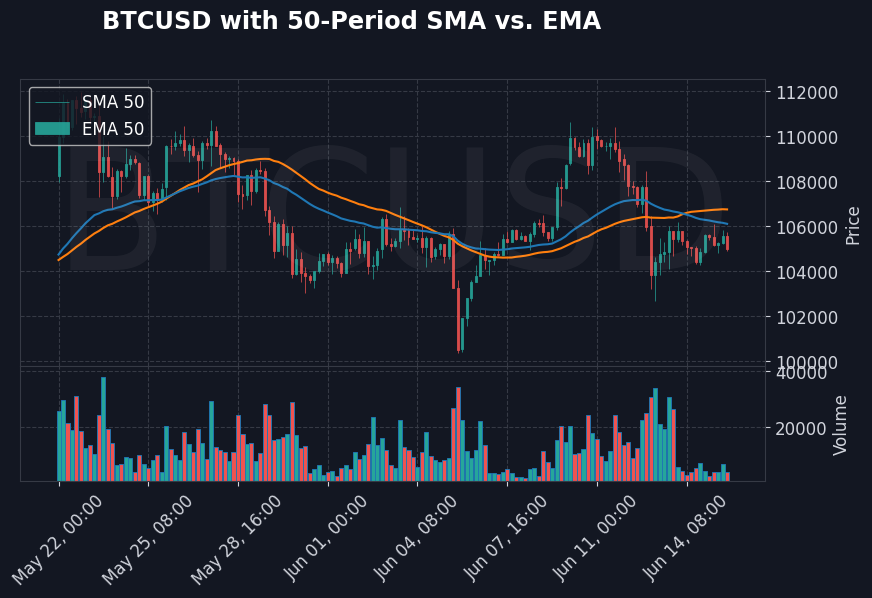

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import mplfinance as mpf
import logging

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- 1. DEFINE OUR CUSTOM TRADINGVIEW STYLE ---
tv_marketcolors = mpf.make_marketcolors(up='#26a69a', down='#ef5350', edge='inherit', wick='inherit', volume={'up': '#26a69a', 'down': '#ef5350'})
tv_style = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=tv_marketcolors, facecolor='#131722', edgecolor='#363a45', figcolor='#131722', gridcolor='#363a45', gridstyle='--', y_on_right=True, rc={'font.size':12, 'axes.labelcolor':'#d1d4dc', 'xtick.color':'#d1d4dc', 'ytick.color':'#d1d4dc'})


# --- Main execution block ---
if __name__ == "__main__":
    if not mt5.initialize(): 
        logging.error("initialize() failed")
        mt5.shutdown()
    else:
        # --- A. Fetch Data ---
        SYMBOL = "BTCUSD"
        TIME_FRAME = mt5.TIMEFRAME_H4
        NUM_BARS = 400 # Get enough bars for a 50-period MA to be smooth

        logging.info(f"Fetching {NUM_BARS} bars for {SYMBOL}...")
        rates = mt5.copy_rates_from_pos(SYMBOL, TIME_FRAME, 0, NUM_BARS)
        mt5.shutdown()
        
        if rates is None or len(rates) == 0:
            logging.error("No data fetched. The market may be closed or symbol incorrect.")
        else:
            df = pd.DataFrame(rates)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df.set_index('time', inplace=True)
            df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)

            # --- B. Calculate Both SMA and EMA ---
            period = 50
            df[f'SMA_{period}'] = df['Close'].rolling(window=period).mean()
            df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
            logging.info(f"Calculated {period}-period SMA and EMA.")

            # --- C. Prepare and Create the Plot ---
            df_to_plot = df.tail(150) # Plot the last 150 candles

            # Create addplot objects for each moving average
            ap_sma = mpf.make_addplot(df_to_plot[f'SMA_{period}'], color='#ff7f0e', width=1.5) # Orange for SMA
            ap_ema = mpf.make_addplot(df_to_plot[f'EMA_{period}'], color='#1f77b4', width=1.5) # Blue for EMA
            addplots = [ap_sma, ap_ema]
            
            output_filename = f'{SYMBOL}_SMA_vs_EMA.png'
            
            fig, axlist = mpf.plot(
                df_to_plot,
                type='candle',
                style=tv_style, 
                title=f'{SYMBOL} with 50-Period SMA vs. EMA',
                volume=True,
                addplot=addplots,
                figratio=(18,10),
                returnfig=True
            )

            # Add a legend
            ax_price = axlist[0]
            ax_price.legend([f'SMA {period}', f'EMA {period}'], loc='upper left')
            
            # --- TradingView-style watermark ---
            ax_price = axlist[0]
            ax_price.text(
                0.5, 0.5, SYMBOL,
                transform=ax_price.transAxes,
                fontsize=120,
                color='white',
                alpha=0.05, 
                ha='center',
                va='center'
            )

            fig.savefig(output_filename, dpi=150)
            logging.info(f"Chart successfully saved to '{output_filename}'")